# Predict energy demand in Australia

In [1]:
import os
import glob
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
# from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.inspection import permutation_importance

from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from scipy.stats import pearsonr, randint, uniform
from scipy.spatial.distance import correlation

import matplotlib.pyplot as plt

### Note:

You will need to change the kernel to ml_env to use `mlxtend`

In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

In [5]:
region = "QLD"

### Demand

In [71]:
# demand = pd.read_csv(
#     "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_20091202-20210131.csv",
#     index_col=0,
#     parse_dates=True
# )

In [72]:
# demand = demand.loc[slice("2010", "2020")]

In [73]:
# demand.head()

In [74]:
# demand = demand[region]

In [75]:
# demand.plot()

In [76]:
# dem_da = xr.DataArray(
#     demand.squeeze(),
#     dims=["time"],
#     coords={"time": demand.index.values}
# )

In [77]:
# dem_da = dem_da.expand_dims({"region": [region]})

In [78]:
# dem_da = fn.detrend_dim(dem_da, "time") + dem_da.mean("time")

In [79]:
def rm_weekend(da):
    """
    Set weekend days to NaN
    """
    return da.where(da.time.dt.dayofweek < 5, drop=False)

In [80]:
# dem_da = rm_weekend(dem_da)
# dem_da = dem_da.dropna("time")

In [81]:
dem_da = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020_stl.nc"
)["demand_stl"]

In [82]:
dem_da = dem_da.sel(region=region).expand_dims({"region": [region]})

In [84]:
dem_da = fn.detrend_dim(dem_da, "time") + dem_da.mean("time")

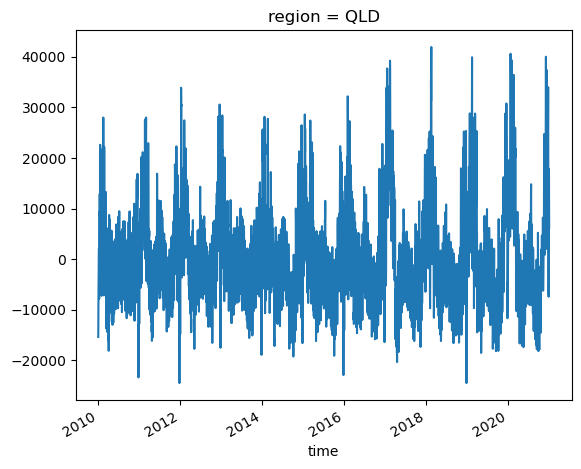

In [85]:
dem_da.plot()

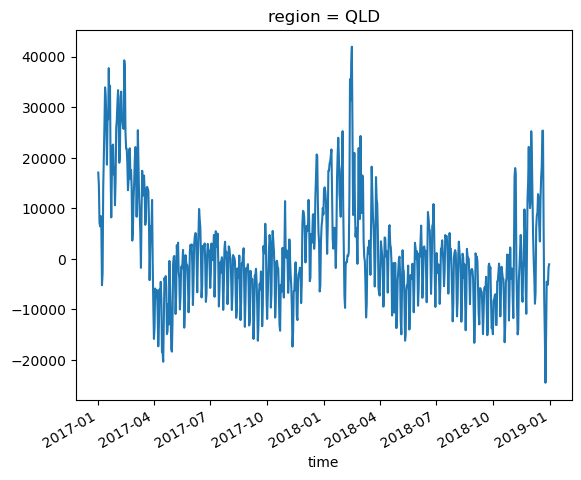

In [86]:
dem_da.sel(time=slice("2017", "2018")).plot()

### Predictors

In [87]:
files = fn.get_predictor_files("NEM", "pop_dens_mask")
files

['/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/mtpr_era5_daily_1959-2022_NEM_pop_dens_mask.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/10w_era5_daily_1959-2022_NEM_pop_dens_mask.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/msdwswrf_era5_daily_1959-2022_NEM_pop_dens_mask.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/rh_era5_daily_1959-2022_NEM_pop_dens_mask.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/cdd_24_rollmean3_era5_daily_1959-2022_NEM_pop_dens_mask.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/2t_rollmean4_era5_daily_1959-2022_NEM_pop_dens_mask.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/2tmin_era5_daily_1959-2022_NEM_pop_dens_mask.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/2tmax_era5_daily_1959-2022_NEM_pop_dens_mask.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/hdd_18_ro

In [88]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override")

In [89]:
pred_ds = pred_ds.sel(region=region).expand_dims({"region": [region]}).compute()

In [90]:
# pred_ds = rm_weekend(pred_ds)
# pred_ds = pred_ds.dropna("time")

In [91]:
pred_ds.data_vars

Data variables:
    mtpr      (region, time) float64 1.095e-05 0.0001228 ... 3.755e-05 2.378e-05
    w10       (region, time) float64 1.729 2.745 1.706 ... 4.006 3.598 3.298
    msdwswrf  (region, time) float64 292.7 212.9 181.8 ... 213.4 167.6 247.2
    rh        (region, time) float64 75.34 83.73 87.18 ... 74.63 80.44 74.64
    cdd3      (region, time) float64 nan nan 0.7129 ... 0.1788 0.2727 0.3258
    t2m4      (region, time) float64 nan nan nan 296.8 ... 295.9 296.0 296.2
    t2min     (region, time) float64 nan 294.4 292.6 292.8 ... 294.0 293.5 293.3
    t2max     (region, time) float64 nan 301.8 298.4 302.4 ... 299.6 298.2 299.2
    hdd4      (region, time) float64 nan nan nan ... -0.03654 -0.03655 -0.03667
    q         (region, time) float64 14.98 15.33 14.88 ... 13.75 14.32 13.54
    cdd4      (region, time) float64 nan nan nan 0.7151 ... 0.1618 0.2292 0.2844
    hdd       (region, time) float64 0.03668 0.03769 ... -0.03667 -0.03668
    cdd       (region, time) float64 1.107 

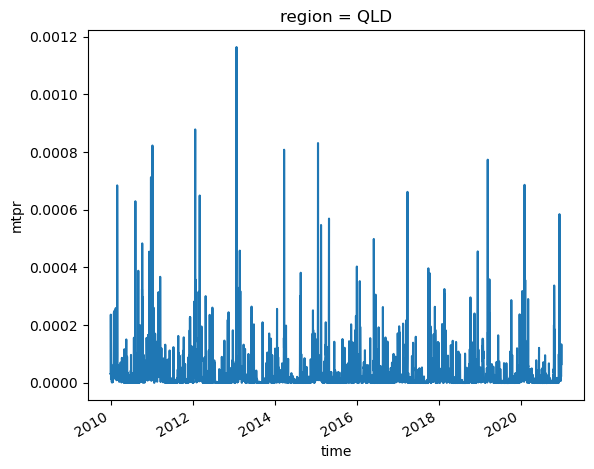

In [92]:
pred_ds.mtpr.sel(time=slice("2010", "2020")).plot()

## Prepare data

In [93]:
# time_cols = ["is_weekend", "month_sin", "month_cos"]
# time_cols = ["is_weekend", "month_int"]
# time_cols = ["is_weekend", "season_int"]
# time_cols = ["is_weekend", "is_transition"]
time_cols = ["is_weekend"]
# time_cols = []

region_dfs = {}
for region in dem_da.region.values:
    df = fn.to_dataframe(dem_da, pred_ds, region)
    for t in time_cols:
        df = fn.add_time_column(df, t)
    new_cols = np.append(np.append("demand", time_cols), df.columns[:-(len(time_cols) + 1)])
    df = df[new_cols]
    region_dfs[region] = df

In [94]:
# region_dfs[region]["year"] = region_dfs[region].index.year

In [95]:
region_dfs[region]

,demand,is_weekend,mtpr,w10,msdwswrf,rh,cdd3,t2m4,t2min,t2max,hdd4,q,cdd4,hdd,cdd,t2m3,hdd3,t2m
2010-01-01,-15391.874336,0,0.000030,2.552129,188.537223,78.151580,0.738437,297.767957,295.019211,300.196507,-0.021746,15.521469,0.735005,-0.021779,0.940108,297.772190,-0.021732,298.021588
2010-01-02,-8826.373212,1,0.000029,2.226117,229.982578,77.244433,1.224513,298.141570,295.987720,301.492951,-0.021749,16.552560,1.077791,-0.021782,2.095943,298.307511,-0.021785,299.249797
2010-01-03,-6208.350416,1,0.000236,2.995689,237.284350,79.931203,1.406075,298.305167,295.245068,303.850402,-0.021789,16.141134,1.213939,-0.021785,1.182306,298.523102,-0.021788,298.298232
2010-01-04,-2943.902111,0,0.000023,4.421680,185.918602,75.317741,1.218860,298.125030,294.611936,299.160990,-0.021426,13.984067,1.149150,-0.020322,0.378463,298.159532,-0.021302,296.930894
2010-01-05,-2706.129539,0,0.000012,3.157716,206.705011,76.112122,0.660630,297.917533,294.604593,299.870778,-0.021429,14.369416,1.019436,-0.021792,0.421253,297.473475,-0.021305,297.191601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,-751.217467,1,0.000021,2.519744,284.837537,69.969443,0.241964,296.546313,293.222756,300.578984,-0.034103,13.086616,0.304771,-0.034372,0.372720,296.448481,-0.034007,297.019946
2020-12-28,8122.921407,0,0.000022,2.401874,312.369659,69.068987,0.478649,296.848768,294.192249,301.985113,-0.034106,13.768882,0.405701,-0.034375,0.897049,297.016834,-0.034010,298.049777
2020-12-29,17872.588409,0,0.000123,1.798015,166.927440,77.786538,0.705400,297.247381,294.414971,300.282527,-0.034109,15.434386,0.570611,-0.034378,0.846638,297.669463,-0.034384,297.939161
2020-12-30,11042.804505,0,0.000133,2.511968,118.707353,84.364283,0.637079,297.276757,293.658369,297.959985,-0.034273,14.967038,0.570954,-0.033913,0.167757,297.362402,-0.034231,296.098765


### Subselect predictors if desired

In [96]:
# region_dfs[region] = region_dfs[region][["demand", "hdd", "cdd"]]

In [97]:
# region_dfs[region].head()

## Split data into training and testing

Using this as a guide: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

As this is time series data, leave out the last two years for testing.

In [98]:
first_train_year = 2010
last_train_year = 2016

In [99]:
first_test_year = 2017
last_test_year = 2019

In [100]:
# Hold out last two years for testing
test_len = dem_da.sel(time=slice(str(first_test_year), str(last_test_year))).time.values.shape[0]

In [101]:
train_X, test_X, train_y, test_y = fn.split(
    fn.sel_train_test(region_dfs[region], first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [102]:
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(2557, 17) (1095, 17) (2557,) (1095,)


## Sequential feature selection

Chooses the predictors using forwards selection and a stopping criterion for a score.

In [103]:
# rf = RandomForestRegressor(
#     n_estimators=best_params["n_estimators"],
#     random_state=0
# )

In [104]:
rf = ExtraTreesRegressor(
    random_state=0
)

In [105]:
logo = fn.leave_one_group_out(
    train_X,
    train_y,
    dem_da.sel(time=slice(str(first_train_year), str(last_train_year))),
    str(first_train_year),
    str(last_train_year)
)

[2010 2010 2010 ... 2016 2016 2016]


In [106]:
%%time
model = fn.mlextend_sfs(train_X, train_y, rf, list(logo), True, scoring="neg_mean_absolute_error")

CPU times: user 8min 6s, sys: 6.8 s, total: 8min 13s
Wall time: 8min 13s


In [107]:
model.subsets_

{1: {'feature_idx': (0,),
  'cv_scores': array([-4157.44573826, -5524.69663801, -5421.28089522, -4332.08561436,
         -5930.52356902, -5882.95866498, -5979.74209089]),
  'avg_score': -5318.39045867746,
  'feature_names': ('0',)},
 2: {'feature_idx': (0, 16),
  'cv_scores': array([-4634.99847865, -4205.8765616 , -4187.45940518, -4101.46188169,
         -4471.3857818 , -4325.55872049, -3926.27254958]),
  'avg_score': -4264.716196997356,
  'feature_names': ('0', '16')},
 3: {'feature_idx': (0, 3, 16),
  'cv_scores': array([-3703.68449023, -3606.40086796, -3754.60734708, -3241.20512778,
         -3423.76006418, -3242.47058749, -3021.71721641]),
  'avg_score': -3427.692243018049,
  'feature_names': ('0', '3', '16')},
 4: {'feature_idx': (0, 3, 10, 16),
  'cv_scores': array([-3625.15560591, -3558.8622148 , -3546.37989039, -2970.37185632,
         -3259.67560754, -2984.15454394, -2862.48009767]),
  'avg_score': -3258.154259510789,
  'feature_names': ('0', '3', '10', '16')},
 5: {'feature_i

In [108]:
model.k_feature_idx_

(0, 2, 3, 5, 8, 9, 10, 12, 15, 16)

In [109]:
selected_features = list(region_dfs[region].columns[1:][list(model.k_feature_idx_)])
print(selected_features)

['is_weekend', 'w10', 'msdwswrf', 'cdd3', 't2max', 'hdd4', 'q', 'hdd', 'hdd3', 't2m']


In [110]:
pd.DataFrame.from_dict(model.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(0,)","[-4157.4457382618275, -5524.696638012432, -542...",-5318.390459,"(0,)",683.053603,707.568145,288.863486
2,"(0, 16)","[-4634.998478648444, -4205.876561599427, -4187...",-4264.716197,"(0, 16)",210.915333,218.485007,89.19613
3,"(0, 3, 16)","[-3703.684490230147, -3606.4008679569347, -375...",-3427.692243,"(0, 3, 16)",244.461892,253.235539,103.382976
4,"(0, 3, 10, 16)","[-3625.1556059056466, -3558.8622147968235, -35...",-3258.15426,"(0, 3, 10, 16)",287.910474,298.243474,121.757389
5,"(0, 3, 10, 15, 16)","[-3391.8675554088445, -3423.1437813003836, -33...",-3149.386279,"(0, 3, 10, 15, 16)",232.010652,240.337429,98.117345
6,"(0, 3, 5, 10, 15, 16)","[-3438.5554719430374, -3387.947667213619, -335...",-3098.973561,"(0, 3, 5, 10, 15, 16)",270.114078,279.808373,114.23129
7,"(0, 2, 3, 5, 10, 15, 16)","[-3406.2811202240055, -3403.8562650178674, -33...",-3072.709306,"(0, 2, 3, 5, 10, 15, 16)",285.784732,296.041441,120.858412
8,"(0, 2, 3, 5, 10, 12, 15, 16)","[-3381.2624793001564, -3412.1326495662593, -32...",-3033.040111,"(0, 2, 3, 5, 10, 12, 15, 16)",281.986508,292.1069,119.252143
9,"(0, 2, 3, 5, 8, 10, 12, 15, 16)","[-3308.611208663765, -3398.7661226775904, -330...",-3015.140248,"(0, 2, 3, 5, 8, 10, 12, 15, 16)",292.809348,303.318168,123.829124
10,"(0, 2, 3, 5, 8, 9, 10, 12, 15, 16)","[-3381.2212051284373, -3351.7408869321707, -32...",-3003.791439,"(0, 2, 3, 5, 8, 9, 10, 12, 15, 16)",293.114105,303.633862,123.958005


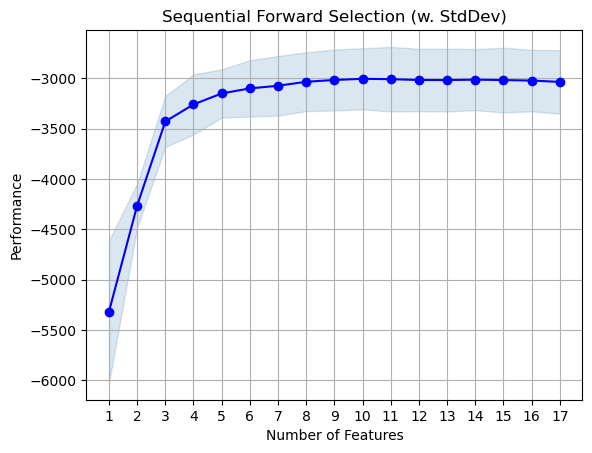

In [111]:
fig1 = plot_sfs(model.get_metric_dict(), kind='std_dev')
# plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

## Tune hyperparameters

Using leave one group out cross validation, where a group is a year.

In [112]:
parameters = {
    "n_estimators": randint(200, 500), # no. trees in the forest
    "min_samples_leaf": randint(5, 30), # min no. samples at leaf node
    "max_depth" : randint(5, 50), # max depth of each tree
    # "max_features" : uniform(0.2, 1) # max proportion of features to consider at split
    "max_leaf_nodes": randint(20, 200) # size of tree, how many end nodes
}

In [113]:
retain = ["demand"] + selected_features

In [114]:
final_features = region_dfs[region][retain]

In [115]:
final_features.head()

,demand,is_weekend,w10,msdwswrf,cdd3,t2max,hdd4,q,hdd,hdd3,t2m
2010-01-01,-15391.874336,0,2.552129,188.537223,0.738437,300.196507,-0.021746,15.521469,-0.021779,-0.021732,298.021588
2010-01-02,-8826.373212,1,2.226117,229.982578,1.224513,301.492951,-0.021749,16.552560,-0.021782,-0.021785,299.249797
2010-01-03,-6208.350416,1,2.995689,237.284350,1.406075,303.850402,-0.021789,16.141134,-0.021785,-0.021788,298.298232
2010-01-04,-2943.902111,0,4.421680,185.918602,1.218860,299.160990,-0.021426,13.984067,-0.020322,-0.021302,296.930894
2010-01-05,-2706.129539,0,3.157716,206.705011,0.660630,299.870778,-0.021429,14.369416,-0.021792,-0.021305,297.191601


In [116]:
train_X, test_X, train_y, test_y = fn.split(
    fn.sel_train_test(final_features, first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [117]:
# # very restricted space for testing
# parameters = {
#     "n_estimators": randint(10, 12), # no. trees in the forest
# }

In [118]:
rf = ExtraTreesRegressor()

In [119]:
logo = fn.leave_one_group_out(train_X, train_y, dem_da, str(first_train_year), str(last_train_year))

[2010 2010 2010 ... 2016 2016 2016]


In [120]:
%%time
best_params = fn.tune_hyperparameters(
    train_X,
    train_y,
    rf,
    parameters,
    logo,
    n_iter=200
)

CPU times: user 13min 25s, sys: 1.36 s, total: 13min 26s
Wall time: 13min 26s


In [121]:
best_params

{'max_depth': 21,
 'max_leaf_nodes': 177,
 'min_samples_leaf': 5,
 'n_estimators': 415}

## Finalise model

In [122]:
rf = ExtraTreesRegressor(
    n_estimators=best_params["n_estimators"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_depth=best_params["max_depth"],
    max_leaf_nodes=best_params["max_leaf_nodes"],
    random_state=0,
)

In [123]:
model_train, pred_train = fn.predict_forest(train_y, train_X, train_X, rf)

In [124]:
model_test, pred_test = fn.predict_forest(train_y, train_X, test_X, rf)

In [125]:
pred_train.shape

(2557,)

In [126]:
pred_test.shape

(1095,)

## Evaluate performance

In [127]:
metric_names = ["R2", "MAE", "MSE", "MAPE", "MedAE"]
metrics = [r2_score, mean_absolute_error,
           mean_squared_error, mean_absolute_percentage_error, median_absolute_error]

In [128]:
train_scores = fn.compute_scores(train_y, pred_train, metrics)

In [129]:
train_scores

[0.8527411245903773,
 2298.7375915150856,
 10277220.20313252,
 2.1148419135350323,
 1767.043921193208]

In [130]:
test_scores = fn.compute_scores(test_y, pred_test, metrics)

In [131]:
test_scores

[0.8223722396263077,
 3365.691354135882,
 20529667.26927881,
 1.512094520199333,
 2614.4385563448504]

In [132]:
def plot_scores(train, test, metric_names):
    """
    Subplot for each metric showing score for train and test.
    """
    fig, ax = plt.subplots(2, 3, figsize=(6, 3))
    for i, a in enumerate(ax.flatten()):
        if i < len(metric_names):
            a.bar(["Train", "Test"], [train[i], test[i]])
            a.set_title(metric_names[i])
    plt.tight_layout()

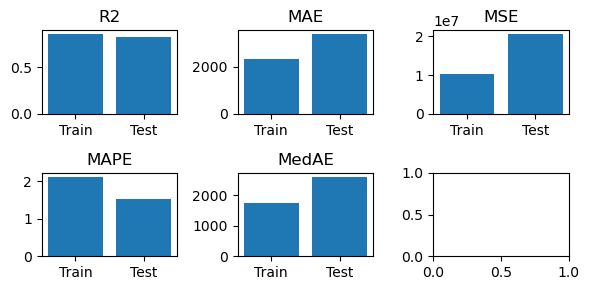

In [133]:
plot_scores(train_scores, test_scores, metric_names)

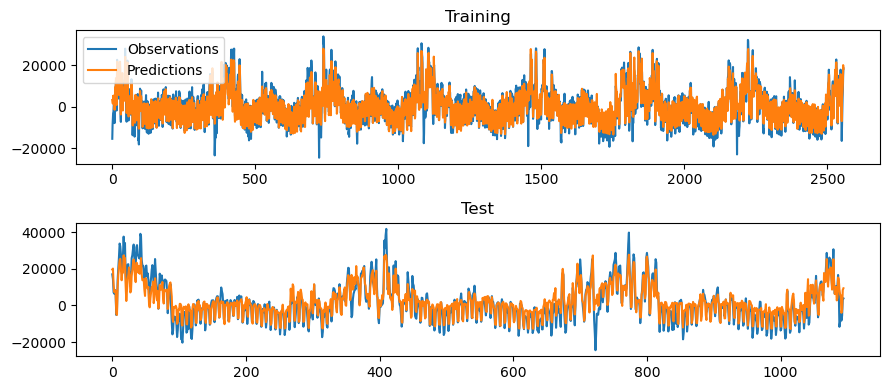

In [134]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

ax[0].plot(train_y, label="Observations")
ax[0].plot(pred_train, label="Predictions")
ax[0].legend()
ax[0].set_title("Training")

ax[1].plot(test_y)
ax[1].plot(pred_test)
ax[1].set_title("Test")

plt.tight_layout()

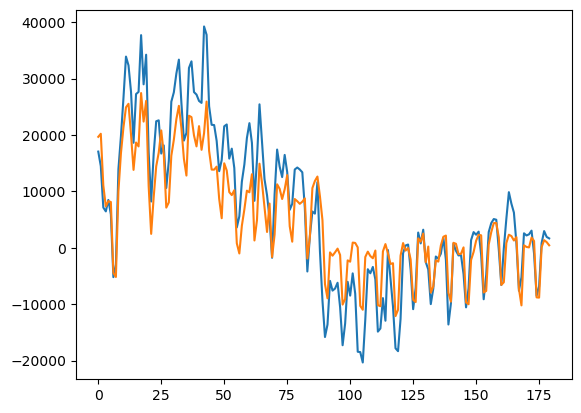

In [135]:
plt.plot(test_y[:180])
plt.plot(pred_test[:180])

## Permutation importances

Compute these on the training and test sets. Differences tell us what the model actually used to make the predictions.

In [78]:
perm_train = fn.perm_imp(
    model_train,
    train_X,
    train_y,
    n_repeats=200,
)

In [79]:
perm_test = fn.perm_imp(
    model_test,
    test_X,
    test_y,
    n_repeats=200,
)

In [80]:
perm_train

{'importances_mean': array([0.13995164, 0.01626925, 0.10572489, 0.07931434, 0.05082711,
        0.11471596, 0.02440561, 0.00493057, 0.03010124, 0.01219024]),
 'importances_std': array([0.00767917, 0.00085208, 0.00473147, 0.00350224, 0.00266331,
        0.00494296, 0.00123989, 0.00032476, 0.00184531, 0.00062019]),
 'importances': array([[0.13823381, 0.14006429, 0.13473595, ..., 0.14147323, 0.15898924,
         0.14590845],
        [0.01666628, 0.01584424, 0.01472775, ..., 0.01520337, 0.01683122,
         0.01746151],
        [0.09569864, 0.10335834, 0.11467901, ..., 0.10444087, 0.09852746,
         0.10132439],
        ...,
        [0.00420485, 0.00487804, 0.00512109, ..., 0.00493622, 0.00463681,
         0.00488321],
        [0.02698144, 0.03150382, 0.03180216, ..., 0.03053448, 0.0288593 ,
         0.03003869],
        [0.01080903, 0.01258779, 0.01293996, ..., 0.01263043, 0.01205979,
         0.01205937]])}

In [81]:
perm_test

{'importances_mean': array([0.07746051, 0.00150864, 0.11290801, 0.06718211, 0.01717762,
        0.11936247, 0.00826919, 0.00018062, 0.02204301, 0.00619968]),
 'importances_std': array([0.00894955, 0.00101213, 0.00718671, 0.00447685, 0.00376282,
        0.00779727, 0.00141239, 0.00031644, 0.00335353, 0.00105301]),
 'importances': array([[ 7.85418244e-02,  7.94944138e-02,  7.75581507e-02, ...,
          7.40198859e-02,  7.20541268e-02,  7.35219301e-02],
        [ 2.74295163e-03,  1.16625889e-03, -9.18489994e-05, ...,
          2.88342405e-03,  1.37960546e-03,  1.84245141e-03],
        [ 1.17367972e-01,  1.15038405e-01,  1.17089528e-01, ...,
          9.82815625e-02,  9.94207390e-02,  1.18130334e-01],
        ...,
        [-4.57788609e-04,  3.76797985e-04, -3.18489614e-05, ...,
          4.30664278e-04,  1.58781701e-04,  4.43500560e-04],
        [ 2.41954804e-02,  2.37801136e-02,  2.25581075e-02, ...,
          2.06896959e-02,  2.22267538e-02,  2.19887514e-02],
        [ 7.13391174e-03,  

In [82]:
fn.print_perm_imp(perm_train, selected_features)

is_weekend 0.140 +/- 0.008
t2max    0.115 +/- 0.005
t2m      0.106 +/- 0.005
t2m3     0.079 +/- 0.004
w10      0.051 +/- 0.003
cdd3     0.030 +/- 0.002
msdwswrf 0.024 +/- 0.001
q        0.016 +/- 0.001
cdd4     0.012 +/- 0.001
mtpr     0.005 +/- 0.000


In [83]:
fn.print_perm_imp(perm_test, selected_features)

t2max    0.119 +/- 0.008
t2m      0.113 +/- 0.007
is_weekend 0.077 +/- 0.009
t2m3     0.067 +/- 0.004
cdd3     0.022 +/- 0.003
w10      0.017 +/- 0.004
msdwswrf 0.008 +/- 0.001
cdd4     0.006 +/- 0.001
